In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import conv2d
import functools
from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from functools import partial
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
from crf.gaussian_matrix import LatticeGaussian, LatticeFilter#, LSHGaussian

In [3]:
from crf.utils import read_image, read_pfm, read_pgm
from crf.features import Vgg16features
from crf.crf import *
from crf.depth import *

In [4]:
img1 = read_image('imL.png')#[::2,::2]
img2 = read_image('imR.png')#[::2,::2]
gt_depth = read_pgm('truedisp.row3.col3.pgm')
#img1 = read_image('im0.png')[::3,::3]
#img2 = read_image('im1.png')[::3,::3]
#gt_depth = read_pfm('disp0.pfm')[::3,::3]
device = torch.device('cuda')#torch.device('cuda')#torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
q = 0
# Get random projection of VGG16 features
VGG = Vgg16features()
VGG.to(device)
VGG.eval()
features = VGG.get_features(img1,k=q+1)
torch_features = torch.from_numpy(features[q]).to(device).detach()

In [6]:
img1.shape

(288, 384, 3)

In [7]:
np.tile(np.mgrid[:3,:4],(5,1,1,1,1)).shape

(5, 1, 2, 3, 4)

In [8]:
d=5
class ReferenceMatrix(nn.Module):
    def __init__(self):
        super().__init__()
        self.projection = nn.Linear(64,d)
        self.sigma_c = nn.Parameter(torch.tensor(.1).float())
        self.sigma_p = nn.Parameter(torch.tensor(.1).float())
    def forward(self,img,nn_features):
        projected_features = self.projection(nn_features)
        scaled_rgb = torch.from_numpy(img).float()/self.sigma_c
        h,w,_ = img.shape
        ij = torch.from_numpy(np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)).float()
        scaled_ij = ij/self.sigma_p
        #print(ij.shape,scaled_rgb.shape, projected_features.shape)
        return torch.cat([scaled_ij,scaled_rgb,projected_features],dim=-1).reshape(h*w,5+d)#
    
class denseCRF(nn.Module):
    def __init__(self,n_iters=5,num_classes=48):
        super().__init__()
        self.device = torch.device('cpu')
        self.n_iters = n_iters
        self.reference = ReferenceMatrix()
        self.labels = torch.arange(num_classes).float().to(self.device)
        self.Mu = compatibility_matrix(partial(charbonneir,gamma=3),self.labels)
        self.w1 = nn.Parameter(torch.tensor(1).float())
        self.E_weight = nn.Parameter(torch.tensor(1).float())
        
        
    def forward(self,E,img,nn_features):
        ref = self.reference(img,nn_features)
        W = LatticeGaussian(ref)
        Q_out = mean_field_infer(E_0*self.E_weight,W,self.Mu*self.w1,self.n_iters)
        expected_depths = Q_out@self.labels
        return expected_depths
    
class denseCRF2(nn.Module):
    def __init__(self,n_iters=5,num_classes=48):
        super().__init__()
        self.device = torch.device('cuda')
        self.CRFlayer = CRFasRNN(num_classes,n_iters)
        self.CRFguide = nn.Sequential()
        self.labels = torch.arange(num_classes).float().to(self.device)
    def forward(self,E0,x):
        guide = self.CRFguide(x)
        filtered = self.CRFlayer(E0.to(self.device)[None,...],guide.to(self.device)[None,...])
        return (filtered.squeeze().permute(1,2,0).reshape(-1,len(self.labels))@self.labels).cpu()

In [9]:
## Hyper parameters
ws = 9      # Disparity aggregation window size
gamma = 3    # Charbonneir turning point
sigma_c = .1#.15#.1#.1 # Filter stdev for color channels
sigma_p = .1#.08#.1 # Filter stdev for position channels
sigma_f = 3#3#10#3.46#10 # Filter stdev for feature channels
n_iters = 10 # Number of mean field message passing iterations
down_factor = 1

In [10]:
# Get the unary potentials from window sweep
disp_energy = disparity_badness(img1,img2,ws,criterion=AD)
disps = np.argmin(disp_energy,axis=-1)
L = disp_energy.shape[-1] # Number of possible disparities
downsampled_out = disp_energy[::down_factor,::down_factor]
h,w,_ = downsampled_out.shape
n = h*w

E_0 = torch.from_numpy(downsampled_out.reshape(-1,L)).float().to(device)
P_0 = F.softmax(-E_0,dim=1)

In [11]:
# with torch.no_grad():
#     mf = mean_field_infer(E_0,W,Mu,n_iters)
#     expected_depths = mf@labels.to(device)#.max(dim=-1)[1]#@labels.to(device)
#     crf_depth = expected_depths.reshape(h,w).cpu().numpy()
labels = torch.arange(L).float()
baseline_depth = (P_0@labels.to(device)).reshape(h,w).cpu().numpy()
D = denseCRF2(n_iters=1).to(device)

In [12]:
# gt = torch.from_numpy(gt_depth.reshape(-1)).float()
# def testrun():
#     crf_depth = D(E_0,img1,torch_features);
#     diff = (4*crf_depth - gt/4)[gt!=0];
#     loss = (diff**2).mean(); loss.backward()
# #%lprun -f LatticeFilter.backward testrun()
# %timeit -n 1 -r 2 testrun()

In [13]:
#%timeit D(torch.cat([E_0]*100,dim=-1),img1,torch_features)

In [14]:
img1.shape

(288, 384, 3)

In [15]:
E0 = E_0.t().reshape(L,h,w).float()
crf_depth0 = D(E0,torch.from_numpy(img1).permute(2,0,1).float()).data.numpy()
gt = torch.from_numpy(gt_depth.reshape(-1)).float()
# Training loop
optimizer = torch.optim.Adam(D.parameters(),lr=3e-2,betas=(.9,.9))
num_steps=500
def train_step(i):
    optimizer.zero_grad()
    crf_depth = D(E0,torch.from_numpy(img1).permute(2,0,1).float())
    #print(crf_depth.shape)
    #print(gt.shape)
    diff = (4*crf_depth - gt/4)[gt!=0]
    loss = (diff*diff).mean()
    loss.backward()
    optimizer.step()
    if not i%10: print(loss.item())
    #mem_report()
for i in range(num_steps):
#     with torch.no_grad():
#         crf_depth = D(E_0,img1,torch_features)#train_step()
    train_step(i)
#%lprun -f train_step train_step()
# with torch.autograd.profiler.profile() as prof:
#     train_step()
# print(prof)
#print(list(D.parameters()))

28.842897415161133
21.623485565185547
22.110746383666992
20.9019775390625
19.80708122253418
18.509183883666992
17.25095558166504
15.855298042297363
14.451882362365723
13.616849899291992
13.31476879119873
13.160293579101562
13.053926467895508
12.629657745361328
12.66557788848877
12.387812614440918
12.193964004516602
12.115167617797852
12.10002326965332
11.910311698913574
11.900420188903809
11.856107711791992
11.669574737548828
11.488593101501465
11.35898208618164
11.21335220336914
11.165762901306152
10.972090721130371
11.045358657836914
10.895699501037598
10.796968460083008
10.664284706115723
10.759434700012207
10.307352066040039
25.92604637145996
11.552019119262695
11.788111686706543
11.626043319702148
11.525568008422852
11.43487548828125
11.362687110900879
11.285439491271973
11.099084854125977
11.121023178100586
10.959490776062012
10.800334930419922
10.77647590637207
10.735868453979492
10.627150535583496
10.570647239685059


Text(0.5, 1.0, 'Ground Truth')

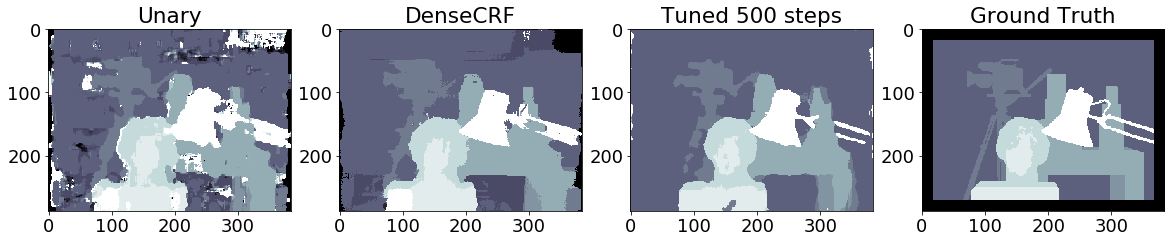

In [16]:
crf_depth = D(E0,torch.from_numpy(img1).permute(2,0,1).float())
plt.rcParams.update({'font.size': 18})
f, axarr = plt.subplots(1,4,figsize=(20,10))
a0 = axarr[0].imshow(4*baseline_depth,cmap='bone',vmin=0,vmax=L)
a1 = axarr[1].imshow(4*crf_depth0.reshape(baseline_depth.shape),cmap='bone',vmin=0,vmax=L)
a2 = axarr[2].imshow(4*crf_depth.cpu().data.numpy().reshape(baseline_depth.shape),cmap='bone',vmin=0,vmax=L)
a3 = axarr[3].imshow(gt_depth/4,cmap='bone',vmin=0,vmax=L)
axarr[0].set_title("Unary")
axarr[1].set_title("DenseCRF")
axarr[2].set_title("Tuned {} steps".format(num_steps))
axarr[3].set_title("Ground Truth")

In [ ]:
gt_depth

In [ ]:
plt.imshow(img1)
plt.show()

In [ ]:
featss = VGG.get_all_features(img1)

In [ ]:
for i in range(4):
    print(featss[i].shape)

In [ ]:
for d in range(4):
    ff  =featss[d]
    for i in range(ff.shape[-1]):
        plt.imshow(ff[:,:,i])
        plt.show()

In [ ]:
list(D.reference.parameters())

In [ ]:
D.reference.sigma_c